In [1]:
import sys
sys.path.insert(1, "../")
import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [3]:
protected = ["sex"]
privileged_classes = [['Male']]
mapping = default_mappings.copy()
mapping['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]


# privileged_groups = [{key:1 for key in protected}]
# unprivileged_groups = [{key:0 for key in protected}]

random_state = 47

In [4]:
beta = 1
alpha = 0.5

In [5]:
train_fd = FairDataset(100, 2,
                       protected_attribute_names=['sex'],
                       privileged_classes=[['Male']],
                       random_state=random_state,
                       metadata=mapping,
                       alpha=alpha,
                       beta=beta)
train_fd_x, train_fd_y = train_fd.get_xy(keep_protected = False)

In [6]:
df, _ = train_fd.convert_to_dataframe()
print(len(df))
print(np.unique(train_fd.protected_attributes, return_counts=True))

200
(array([0., 1.]), array([100, 100], dtype=int64))


In [7]:
lmod = LogisticRegression(class_weight='balanced', 
                          solver='lbfgs',
                          verbose=2,
                         penalty='none',
                         random_state=47)
lmod.fit(train_fd_x, train_fd_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=47, solver='lbfgs', tol=0.0001,
                   verbose=2, warm_start=False)

In [8]:
test_fd = FairDataset(100, 2, 
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                      random_state=23,
                      alpha=alpha,
                      beta=beta,
                      metadata=mapping)
test_fd_x, test_fd_y = test_fd.get_xy(keep_protected = False)

In [9]:
predictions = lmod.predict(test_fd_x)

In [10]:
print(len(test_fd_x))
print(lmod.coef_)

200
[[0.50609467 0.61496468]]


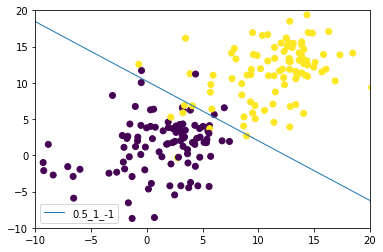

In [12]:
plot_lr_boundary(lmod, plt, '_'.join([str(x) for x in [alpha, beta, -1]]))
plt.scatter(test_fd_x['0'], test_fd_x['1'], c=test_fd_y, label=None)
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.legend()

In [19]:
def alpha_beta_variation(alpha, beta, test_fd, regularizer='none'):
    train_fd = FairDataset(100, 2,
                       protected_attribute_names=['sex'],
                       privileged_classes=[['Male']],
                       random_state=random_state,
                       metadata=mapping,
                       alpha=alpha,
                       beta=beta)
    train_fd_x, train_fd_y = train_fd.get_xy(keep_protected = False)
    print(np.unique(train_fd.protected_attributes, return_counts=True))
    lmod = LogisticRegression(class_weight='balanced', 
                              solver='lbfgs',
                              verbose=2,
                              penalty=regularizer, C=1e-4)
    lmod.fit(train_fd_x, train_fd_y)
    test_fd_x, test_fd_y = test_fd.get_xy(keep_protected = False)
    predictions = lmod.predict(test_fd_x)
    cm = get_classifier_metrics(lmod, test_fd)
    di = cm[1]
    plot_lr_boundary(lmod, plt, '_'.join([str(x) for x in [alpha, beta, di]]))
    plt.scatter(test_fd_x['0'], test_fd_x['1'], c=test_fd_y, label=None)
    plt.xlim(-10, 20)
    plt.ylim(-10, 20)

In [20]:
test_fd = FairDataset(500, 2, 
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                      random_state=1,
                      alpha=0.5,
                      beta=1,
                      metadata=mapping)

(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))

c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


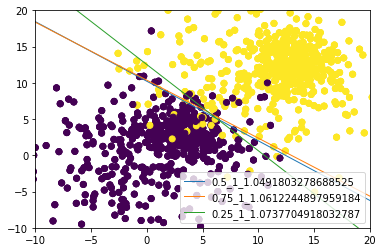

In [21]:
alpha_betas = [[0.5, 1],
              [.75, 1],
              [.25, 1]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd)
    plt.legend()

(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


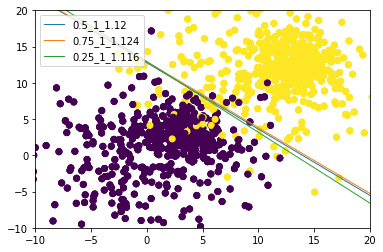

In [22]:
alpha_betas = [[0.5, 1],
              [.75, 1],
              [.25, 1]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd, 'l2')
    plt.legend()

(array([0., 1.]), array([100, 150], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))


c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(array([0., 1.]), array([100,  50], dtype=int64))


c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


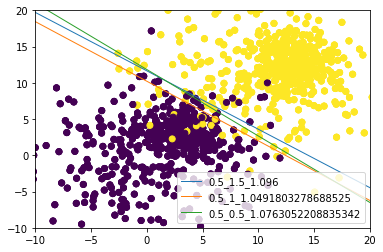

In [23]:
alpha_betas = [[0.5, 1.5],
              [.5, 1],
              [.5, 0.5]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd)
    plt.legend()

(array([0., 1.]), array([100, 150], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished



(array([0., 1.]), array([100,  50], dtype=int64))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


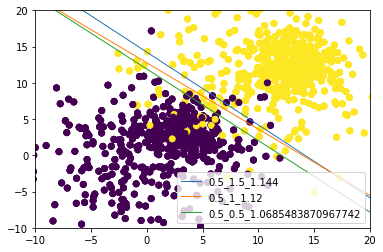

In [24]:
alpha_betas = [[0.5, 1.5],
              [.5, 1],
              [.5, 0.5]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd, 'l2')
    plt.legend()

(array([0., 1.]), array([100, 500], dtype=int64))
(array([0., 1.]), array([100, 500], dtype=int64))


c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(array([0., 1.]), array([100, 500], dtype=int64))


c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


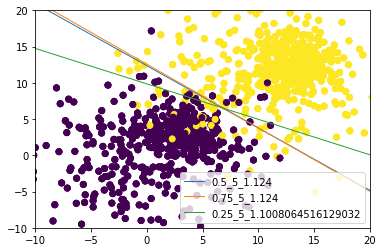

In [25]:
alpha_betas = [[0.5, 5],
              [.75, 5],
              [.25, 5]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd)
    plt.legend()